In [26]:
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.apps import config
from finrl.drl_agents.stablebaselines3.models import DRLAgent


from matplotlib import pyplot as plt
import pandas as pd
import itertools
from utils import *
from ac import Actor, Critic
import numpy as np


import torch
from stable_baselines3 import A2C


%matplotlib inline

In [2]:
ticker_list=['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', \
             'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', \
             'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']
yfp = YahooFinanceProcessor()

In [3]:
data = yfp.download_data(start_date='2009-01-01', end_date='2021-01-01', ticker_list=ticker_list, time_interval='1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
fe = FeatureEngineer(use_turbulence=False)
data = fe.preprocess_data(data)

Successfully added technical indicators


In [5]:
list_ticker = data["tic"].unique().tolist()
list_date = list(pd.date_range(data['date'].min(),data['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

data = pd.DataFrame(combination,columns=["date","tic"]).merge(data,on=["date","tic"],how="left")
data = data[data['date'].isin(data['date'])]
data = data.sort_values(['date','tic'])

data = data.fillna(0)
data.sort_values(['date','tic'],ignore_index=True).head(5)

,date,tic,open,high,low,close,adjcp,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,3.241071,2.778782,746015200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,3.241071,3.241071
1,2009-01-02,AXP,18.570000,19.520000,18.400000,19.330000,15.618549,10955700.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,19.330000,19.330000
2,2009-01-02,BA,42.799999,45.560001,42.779999,45.250000,33.941101,7010200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,45.250000,45.250000
3,2009-01-02,CAT,44.910000,46.980000,44.709999,46.910000,32.475792,7117200.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,46.910000,46.910000
4,2009-01-02,CSCO,16.410000,17.000000,16.250000,16.959999,12.421837,40980600.0,4.0,0.0,3.502909,3.116019,100.0,66.666667,100.0,16.959999,16.959999


In [6]:
gs = data[data['tic'] == 'GS']

In [7]:
train = gs[:int(len(gs)/2)]
test = gs[int(len(gs)/2):]

In [8]:
num_stocks = 1
indicator_list = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
state_space = 1 + 2*num_stocks + len(indicator_list)*num_stocks
env_params = {
                'hmax': 100,
                'initial_amount': 1000000,
                'buy_cost_pct': 0.001,
                'sell_cost_pct': 0.001,
                'reward_scaling': 1e-4,
                'stock_dim': num_stocks,
                'state_space': state_space,
                'tech_indicator_list': indicator_list,
                'action_space': num_stocks
             }

In [9]:
env_train = StockTradingEnv(df=train.reset_index(), **env_params)
env_test = StockTradingEnv(df=test.reset_index(), **env_params)

In [38]:
agent = DRLAgent(env_test)
model = agent.get_model('a2c')
trained = agent.train_model(model=model, tb_log_name="log", total_timesteps=1000000)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 764      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | -0.0013  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 37.1     |
|    reward             | 79.58564 |
|    std                | 0.992    |
|    value_loss         | 2.56e+03 |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 748        |
|    iterations         | 200        |
|    time_elapsed       | 1          |
|    total_timesteps    | 1000       |
| train/              

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 48.4      |
| time/                 |           |
|    fps                | 694       |
|    iterations         | 1300      |
|    time_elapsed       | 9         |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -1.39     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1299      |
|    policy_loss        | -0.0239   |
|    reward             | 0.0       |
|    std                | 0.971     |
|    value_loss         | 0.0004    |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 32.4      |
| time/                 |           |
|    fps                | 683       |
|    iterations         | 1400      |
|    time_el

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 19.4      |
| time/                 |           |
|    fps                | 680       |
|    iterations         | 2500      |
|    time_elapsed       | 18        |
|    total_timesteps    | 12500     |
| train/                |           |
|    entropy_loss       | -1.85     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 2499      |
|    policy_loss        | -0.000114 |
|    reward             | 0.0       |
|    std                | 1.54      |
|    value_loss         | 5.6e-09   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 19.4     |
| time/                 |          |
|    fps                | 681      |
|    iterations         | 2600     |
|    time_elapsed  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 12.1      |
| time/                 |           |
|    fps                | 700       |
|    iterations         | 3700      |
|    time_elapsed       | 26        |
|    total_timesteps    | 18500     |
| train/                |           |
|    entropy_loss       | -2.48     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0007    |
|    n_updates          | 3699      |
|    policy_loss        | -4.87e-06 |
|    reward             | 0.0       |
|    std                | 2.9       |
|    value_loss         | 3.91e-12  |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 12.1     |
| time/                 |          |
|    fps                | 701      |
|    iterations         | 3800     |
|    time_elapsed  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.76     |
| time/                 |          |
|    fps                | 710      |
|    iterations         | 4900     |
|    time_elapsed       | 34       |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -3.06    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4899     |
|    policy_loss        | 0.00148  |
|    reward             | 0.0      |
|    std                | 5.15     |
|    value_loss         | 3.62e-07 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.76     |
| time/                 |          |
|    fps                | 711      |
|    iterations         | 5000     |
|    time_elapsed       | 35       |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.43     |
| time/                 |          |
|    fps                | 718      |
|    iterations         | 6100     |
|    time_elapsed       | 42       |
|    total_timesteps    | 30500    |
| train/                |          |
|    entropy_loss       | -3.42    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 6099     |
|    policy_loss        | -0.00995 |
|    reward             | 0.0      |
|    std                | 7.39     |
|    value_loss         | 1.02e-05 |
------------------------------------
day: 2190, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 996687.94
total_reward: -3312.06
total_cost: 4523.88
total_trades: 252
Sharpe: 0.026
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.88 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 5.96     |
| time/                 |          |
|    fps                | 724      |
|    iterations         | 7300     |
|    time_elapsed       | 50       |
|    total_timesteps    | 36500    |
| train/                |          |
|    entropy_loss       | -3.66    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 7299     |
|    policy_loss        | 0.00672  |
|    reward             | 0.0      |
|    std                | 9.43     |
|    value_loss         | 5.34e-06 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 5.96     |
| time/                 |          |
|    fps                | 724      |
|    iterations         | 7400     |
|    time_elapsed       | 51       |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 4.88     |
| time/                 |          |
|    fps                | 724      |
|    iterations         | 8500     |
|    time_elapsed       | 58       |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -3.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 8499     |
|    policy_loss        | -0.0046  |
|    reward             | 0.0      |
|    std                | 12.1     |
|    value_loss         | 1.6e-06  |
------------------------------------
-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | 4.88          |
| time/                 |               |
|    fps                | 723           |
|    iterations         | 8600          |
|  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 4.11     |
| time/                 |          |
|    fps                | 726      |
|    iterations         | 9700     |
|    time_elapsed       | 66       |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -4.19    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 9699     |
|    policy_loss        | -0.028   |
|    reward             | 0.0      |
|    std                | 16       |
|    value_loss         | 6.59e-05 |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 4.11         |
| time/                 |              |
|    fps                | 726          |
|    iterations         | 9800         |
|    time_

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 3.75        |
| time/                 |             |
|    fps                | 728         |
|    iterations         | 10900       |
|    time_elapsed       | 74          |
|    total_timesteps    | 54500       |
| train/                |             |
|    entropy_loss       | -4.49       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 10899       |
|    policy_loss        | 0.31        |
|    reward             | -0.09454593 |
|    std                | 21.5        |
|    value_loss         | 0.0122      |
---------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 3.58       |
| time/                 |            |
|    fps                | 728        |
|    i

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 3.27     |
| time/                 |          |
|    fps                | 730      |
|    iterations         | 12100    |
|    time_elapsed       | 82       |
|    total_timesteps    | 60500    |
| train/                |          |
|    entropy_loss       | -4.67    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 12099    |
|    policy_loss        | -0.0361  |
|    reward             | 0.0      |
|    std                | 25.9     |
|    value_loss         | 8.43e-05 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 3.27     |
| time/                 |          |
|    fps                | 731      |
|    iterations         | 12200    |
|    time_elapsed       | 83       |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.88     |
| time/                 |          |
|    fps                | 732      |
|    iterations         | 13300    |
|    time_elapsed       | 90       |
|    total_timesteps    | 66500    |
| train/                |          |
|    entropy_loss       | -4.86    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 13299    |
|    policy_loss        | -11.5    |
|    reward             | 0.0      |
|    std                | 31.3     |
|    value_loss         | 4.56     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.88     |
| time/                 |          |
|    fps                | 732      |
|    iterations         | 13400    |
|    time_elapsed       | 91       |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.58     |
| time/                 |          |
|    fps                | 734      |
|    iterations         | 14500    |
|    time_elapsed       | 98       |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -5.04    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 14499    |
|    policy_loss        | -0.0474  |
|    reward             | 0.0      |
|    std                | 37.3     |
|    value_loss         | 0.000125 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.58     |
| time/                 |          |
|    fps                | 734      |
|    iterations         | 14600    |
|    time_elapsed       | 99       |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.38     |
| time/                 |          |
|    fps                | 735      |
|    iterations         | 15700    |
|    time_elapsed       | 106      |
|    total_timesteps    | 78500    |
| train/                |          |
|    entropy_loss       | -5.23    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 15699    |
|    policy_loss        | -0.0491  |
|    reward             | 0.0      |
|    std                | 45.2     |
|    value_loss         | 0.000112 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 2.29      |
| time/                 |           |
|    fps                | 735       |
|    iterations         | 15800     |
|    time_elapsed       | 107  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.15     |
| time/                 |          |
|    fps                | 736      |
|    iterations         | 16900    |
|    time_elapsed       | 114      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -5.36    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 16899    |
|    policy_loss        | -0.0608  |
|    reward             | 0.0      |
|    std                | 51.4     |
|    value_loss         | 0.000149 |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 2.15       |
| time/                 |            |
|    fps                | 736        |
|    iterations         | 17000      |
|    time_elapsed       

-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | 1.88          |
| time/                 |               |
|    fps                | 737           |
|    iterations         | 18100         |
|    time_elapsed       | 122           |
|    total_timesteps    | 90500         |
| train/                |               |
|    entropy_loss       | -5.47         |
|    explained_variance | 0             |
|    learning_rate      | 0.0007        |
|    n_updates          | 18099         |
|    policy_loss        | 0.00704       |
|    reward             | -0.0035824794 |
|    std                | 57.5          |
|    value_loss         | 1.59e-05      |
-----------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 1.88      |
| time/                 |           |
|    fps    

day: 2190, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 972787.77
total_reward: -27212.23
total_cost: 14566.08
total_trades: 716
Sharpe: 0.061
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.6      |
| time/                 |          |
|    fps                | 738      |
|    iterations         | 19300    |
|    time_elapsed       | 130      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -5.63    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19299    |
|    policy_loss        | 4.33     |
|    reward             | 0.0      |
|    std                | 67.2     |
|    value_loss         | 2.83     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.6

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.49     |
| time/                 |          |
|    fps                | 738      |
|    iterations         | 20500    |
|    time_elapsed       | 138      |
|    total_timesteps    | 102500   |
| train/                |          |
|    entropy_loss       | -5.77    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 20499    |
|    policy_loss        | -0.0626  |
|    reward             | 0.0      |
|    std                | 77.9     |
|    value_loss         | 0.000126 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.46     |
| time/                 |          |
|    fps                | 738      |
|    iterations         | 20600    |
|    time_elapsed       | 139      |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.33     |
| time/                 |          |
|    fps                | 739      |
|    iterations         | 21700    |
|    time_elapsed       | 146      |
|    total_timesteps    | 108500   |
| train/                |          |
|    entropy_loss       | -5.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 21699    |
|    policy_loss        | 0.0308   |
|    reward             | 0.0      |
|    std                | 85.3     |
|    value_loss         | 0.000115 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 1.33      |
| time/                 |           |
|    fps                | 739       |
|    iterations         | 21800     |
|    time_elapsed       | 147  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 1.16      |
| time/                 |           |
|    fps                | 739       |
|    iterations         | 22900     |
|    time_elapsed       | 154       |
|    total_timesteps    | 114500    |
| train/                |           |
|    entropy_loss       | -5.96     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 22899     |
|    policy_loss        | -0.105    |
|    reward             | 0.0       |
|    std                | 94        |
|    value_loss         | 0.000429  |
-------------------------------------
-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | 1.16          |
| time/                 |               |
|    fps                | 739           |
|    iterations         | 

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 1.09       |
| time/                 |            |
|    fps                | 739        |
|    iterations         | 24000      |
|    time_elapsed       | 162        |
|    total_timesteps    | 120000     |
| train/                |            |
|    entropy_loss       | -6.04      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 23999      |
|    policy_loss        | 0.0439     |
|    reward             | -0.0019556 |
|    std                | 101        |
|    value_loss         | 0.000801   |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 1.09      |
| time/                 |           |
|    fps                | 739       |
|    iterations         | 24100

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.922      |
| time/                 |            |
|    fps                | 738        |
|    iterations         | 25200      |
|    time_elapsed       | 170        |
|    total_timesteps    | 126000     |
| train/                |            |
|    entropy_loss       | -6.13      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 25199      |
|    policy_loss        | -0.0962    |
|    reward             | -0.0025097 |
|    std                | 111        |
|    value_loss         | 0.000328   |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.922    |
| time/                 |          |
|    fps                | 738      |
|    iterations         | 25300    |


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.865     |
| time/                 |           |
|    fps                | 738       |
|    iterations         | 26400     |
|    time_elapsed       | 178       |
|    total_timesteps    | 132000    |
| train/                |           |
|    entropy_loss       | -6.18     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 26399     |
|    policy_loss        | -0.139    |
|    reward             | 0.0       |
|    std                | 117       |
|    value_loss         | 0.000726  |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 0.865       |
| time/                 |             |
|    fps                | 738         |
|    iterations         | 26500       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.806    |
| time/                 |          |
|    fps                | 739      |
|    iterations         | 27600    |
|    time_elapsed       | 186      |
|    total_timesteps    | 138000   |
| train/                |          |
|    entropy_loss       | -6.29    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 27599    |
|    policy_loss        | 11.6     |
|    reward             | 0.0      |
|    std                | 131      |
|    value_loss         | 8.54     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.77     |
| time/                 |          |
|    fps                | 739      |
|    iterations         | 27700    |
|    time_elapsed       | 187      |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.736     |
| time/                 |           |
|    fps                | 739       |
|    iterations         | 28800     |
|    time_elapsed       | 194       |
|    total_timesteps    | 144000    |
| train/                |           |
|    entropy_loss       | -6.39     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 28799     |
|    policy_loss        | 10.2      |
|    reward             | 6.1928997 |
|    std                | 144       |
|    value_loss         | 6.58      |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 0.736       |
| time/                 |             |
|    fps                | 739         |
|    iterations         | 28900       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.642    |
| time/                 |          |
|    fps                | 739      |
|    iterations         | 30000    |
|    time_elapsed       | 202      |
|    total_timesteps    | 150000   |
| train/                |          |
|    entropy_loss       | -6.45    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 29999    |
|    policy_loss        | 7.11     |
|    reward             | 0.0      |
|    std                | 154      |
|    value_loss         | 2.25     |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.642        |
| time/                 |              |
|    fps                | 739          |
|    iterations         | 30100        |
|    time_

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.534        |
| time/                 |              |
|    fps                | 740          |
|    iterations         | 31200        |
|    time_elapsed       | 210          |
|    total_timesteps    | 156000       |
| train/                |              |
|    entropy_loss       | -6.53        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 31199        |
|    policy_loss        | 4.26         |
|    reward             | -0.016420355 |
|    std                | 167          |
|    value_loss         | 1.87         |
----------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.534    |
| time/                 |          |
|    fps                | 740      |

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.464      |
| time/                 |            |
|    fps                | 736        |
|    iterations         | 32400      |
|    time_elapsed       | 219        |
|    total_timesteps    | 162000     |
| train/                |            |
|    entropy_loss       | -6.54      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 32399      |
|    policy_loss        | -14        |
|    reward             | -0.0020302 |
|    std                | 167        |
|    value_loss         | 4.34       |
--------------------------------------
day: 2190, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 1004924.89
total_reward: 4924.89
total_cost: 20428.73
total_trades: 1002
Sharpe: 0.157
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.41      |
| time/                 |           |
|    fps                | 728       |
|    iterations         | 33600     |
|    time_elapsed       | 230       |
|    total_timesteps    | 168000    |
| train/                |           |
|    entropy_loss       | -6.62     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 33599     |
|    policy_loss        | 0.323     |
|    reward             | -0.001978 |
|    std                | 181       |
|    value_loss         | 0.00875   |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.41     |
| time/                 |          |
|    fps                | 728      |
|    iterations         | 33700    |
|    time_elapsed  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.368     |
| time/                 |           |
|    fps                | 726       |
|    iterations         | 34800     |
|    time_elapsed       | 239       |
|    total_timesteps    | 174000    |
| train/                |           |
|    entropy_loss       | -6.68     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 34799     |
|    policy_loss        | -0.162    |
|    reward             | -8.878219 |
|    std                | 193       |
|    value_loss         | 0.000783  |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.368      |
| time/                 |            |
|    fps                | 727        |
|    iterations         | 34900      |
|    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.291    |
| time/                 |          |
|    fps                | 729      |
|    iterations         | 36000    |
|    time_elapsed       | 246      |
|    total_timesteps    | 180000   |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 35999    |
|    policy_loss        | -0.25    |
|    reward             | 0.0      |
|    std                | 215      |
|    value_loss         | 0.00144  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.291    |
| time/                 |          |
|    fps                | 729      |
|    iterations         | 36100    |
|    time_elapsed       | 247      |
|

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.255        |
| time/                 |              |
|    fps                | 730          |
|    iterations         | 37100        |
|    time_elapsed       | 253          |
|    total_timesteps    | 185500       |
| train/                |              |
|    entropy_loss       | -6.82        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 37099        |
|    policy_loss        | -19.3        |
|    reward             | -0.025454149 |
|    std                | 222          |
|    value_loss         | 8.53         |
----------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.255     |
| time/                 |           |
|    fps                | 731  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.262    |
| time/                 |          |
|    fps                | 732      |
|    iterations         | 38300    |
|    time_elapsed       | 261      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -6.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 38299    |
|    policy_loss        | -0.107   |
|    reward             | 0.0      |
|    std                | 243      |
|    value_loss         | 0.000268 |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.262      |
| time/                 |            |
|    fps                | 733        |
|    iterations         | 38400      |
|    time_elapsed       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.201    |
| time/                 |          |
|    fps                | 735      |
|    iterations         | 39500    |
|    time_elapsed       | 268      |
|    total_timesteps    | 197500   |
| train/                |          |
|    entropy_loss       | -6.95    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 39499    |
|    policy_loss        | 25.3     |
|    reward             | 0.0      |
|    std                | 253      |
|    value_loss         | 35.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.201    |
| time/                 |          |
|    fps                | 735      |
|    iterations         | 39600    |
|    time_elapsed       | 269      |
|

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.15      |
| time/                 |           |
|    fps                | 736       |
|    iterations         | 40700     |
|    time_elapsed       | 276       |
|    total_timesteps    | 203500    |
| train/                |           |
|    entropy_loss       | -6.98     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 40699     |
|    policy_loss        | 15.4      |
|    reward             | 5.3753996 |
|    std                | 261       |
|    value_loss         | 10.7      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.118     |
| time/                 |           |
|    fps                | 737       |
|    iterations         | 40800     |
|    time_el

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.0733     |
| time/                 |            |
|    fps                | 738        |
|    iterations         | 41800      |
|    time_elapsed       | 282        |
|    total_timesteps    | 209000     |
| train/                |            |
|    entropy_loss       | -7.03      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 41799      |
|    policy_loss        | -0.464     |
|    reward             | -4.5396686 |
|    std                | 274        |
|    value_loss         | 0.00582    |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.0733    |
| time/                 |           |
|    fps                | 738       |
|    iterations         | 41900

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.076    |
| time/                 |          |
|    fps                | 740      |
|    iterations         | 43000    |
|    time_elapsed       | 290      |
|    total_timesteps    | 215000   |
| train/                |          |
|    entropy_loss       | -7.06    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 42999    |
|    policy_loss        | 9.13     |
|    reward             | 0.0      |
|    std                | 282      |
|    value_loss         | 5        |
------------------------------------
-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | 0.076         |
| time/                 |               |
|    fps                | 740           |
|    iterations         | 43100         |
|  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.0398    |
| time/                 |           |
|    fps                | 742       |
|    iterations         | 44200     |
|    time_elapsed       | 297       |
|    total_timesteps    | 221000    |
| train/                |           |
|    entropy_loss       | -7.09     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 44199     |
|    policy_loss        | 22.4      |
|    reward             | 12.3728   |
|    std                | 290       |
|    value_loss         | 29.9      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.363   |
| time/                 |          |
|    fps                | 742      |
|    iterations         | 44300    |
|    time_elapsed  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.03      |
| time/                 |            |
|    fps                | 743        |
|    iterations         | 45400      |
|    time_elapsed       | 305        |
|    total_timesteps    | 227000     |
| train/                |            |
|    entropy_loss       | -7.12      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 45399      |
|    policy_loss        | 18.3       |
|    reward             | 0.08374205 |
|    std                | 298        |
|    value_loss         | 17.8       |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.03      |
| time/                 |            |
|    fps                | 743        |
|    iterations         |

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.11     |
| time/                 |           |
|    fps                | 744       |
|    iterations         | 46500     |
|    time_elapsed       | 312       |
|    total_timesteps    | 232500    |
| train/                |           |
|    entropy_loss       | -7.09     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 46499     |
|    policy_loss        | 53.7      |
|    reward             | 0.0       |
|    std                | 290       |
|    value_loss         | 98.8      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.11    |
| time/                 |          |
|    fps                | 744      |
|    iterations         | 46600    |
|    time_elapsed  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.09    |
| time/                 |          |
|    fps                | 746      |
|    iterations         | 47700    |
|    time_elapsed       | 319      |
|    total_timesteps    | 238500   |
| train/                |          |
|    entropy_loss       | -7.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 47699    |
|    policy_loss        | 45.7     |
|    reward             | 0.0      |
|    std                | 300      |
|    value_loss         | 109      |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -1.13        |
| time/                 |              |
|    fps                | 746          |
|    iterations         | 47800        |
|    time_

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.18       |
| time/                 |             |
|    fps                | 747         |
|    iterations         | 48900       |
|    time_elapsed       | 327         |
|    total_timesteps    | 244500      |
| train/                |             |
|    entropy_loss       | -7.2        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 48899       |
|    policy_loss        | 12          |
|    reward             | 0.040062606 |
|    std                | 324         |
|    value_loss         | 7.96        |
---------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.18       |
| time/                 |             |
|    fps                | 747         |


----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -1.11        |
| time/                 |              |
|    fps                | 748          |
|    iterations         | 50100        |
|    time_elapsed       | 334          |
|    total_timesteps    | 250500       |
| train/                |              |
|    entropy_loss       | -7.24        |
|    explained_variance | -2.38e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 50099        |
|    policy_loss        | 18.7         |
|    reward             | -0.038815748 |
|    std                | 337          |
|    value_loss         | 40.8         |
----------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.11      |
| time/                 |            |
|    fps                | 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.11    |
| time/                 |          |
|    fps                | 749      |
|    iterations         | 51200    |
|    time_elapsed       | 341      |
|    total_timesteps    | 256000   |
| train/                |          |
|    entropy_loss       | -7.24    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 51199    |
|    policy_loss        | -0.56    |
|    reward             | 0.0      |
|    std                | 339      |
|    value_loss         | 0.00807  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.16     |
| time/                 |           |
|    fps                | 750       |
|    iterations         | 51300     |
|    time_elapsed       | 341  

-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | -1.2          |
| time/                 |               |
|    fps                | 751           |
|    iterations         | 52400         |
|    time_elapsed       | 348           |
|    total_timesteps    | 262000        |
| train/                |               |
|    entropy_loss       | -7.28         |
|    explained_variance | -2.38e-07     |
|    learning_rate      | 0.0007        |
|    n_updates          | 52399         |
|    policy_loss        | -1.08         |
|    reward             | -0.0018153145 |
|    std                | 351           |
|    value_loss         | 0.0255        |
-----------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.2     |
| time/                 |          |
|    fps         

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.21      |
| time/                 |            |
|    fps                | 752        |
|    iterations         | 53600      |
|    time_elapsed       | 356        |
|    total_timesteps    | 268000     |
| train/                |            |
|    entropy_loss       | -7.3       |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 53599      |
|    policy_loss        | 38.7       |
|    reward             | 0.41635212 |
|    std                | 358        |
|    value_loss         | 90.7       |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.21     |
| time/                 |           |
|    fps                | 752       |
|    iterations         | 53700

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.29    |
| time/                 |          |
|    fps                | 753      |
|    iterations         | 54700    |
|    time_elapsed       | 363      |
|    total_timesteps    | 273500   |
| train/                |          |
|    entropy_loss       | -7.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 54699    |
|    policy_loss        | 4.39     |
|    reward             | 4.5818   |
|    std                | 350      |
|    value_loss         | 1.55     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.38       |
| time/                 |             |
|    fps                | 753         |
|    iterations         | 54800       |
|    time_elapsed

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.39    |
| time/                 |          |
|    fps                | 754      |
|    iterations         | 55900    |
|    time_elapsed       | 370      |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -7.25    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 55899    |
|    policy_loss        | 42.7     |
|    reward             | 18.1624  |
|    std                | 340      |
|    value_loss         | 102      |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.39       |
| time/                 |             |
|    fps                | 754         |
|    iterations         | 56000       |
|    time_elapsed

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.57       |
| time/                 |             |
|    fps                | 755         |
|    iterations         | 57100       |
|    time_elapsed       | 378         |
|    total_timesteps    | 285500      |
| train/                |             |
|    entropy_loss       | -7.25       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 57099       |
|    policy_loss        | 1.87        |
|    reward             | -0.04618047 |
|    std                | 341         |
|    value_loss         | 1.75        |
---------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.57      |
| time/                 |            |
|    fps                | 755        |
|    i

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.51       |
| time/                 |             |
|    fps                | 756         |
|    iterations         | 58300       |
|    time_elapsed       | 385         |
|    total_timesteps    | 291500      |
| train/                |             |
|    entropy_loss       | -7.24       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 58299       |
|    policy_loss        | -2.73       |
|    reward             | 0.067974456 |
|    std                | 338         |
|    value_loss         | 0.195       |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.51    |
| time/                 |          |
|    fps                | 756      |
|    iterations   

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -1.55        |
| time/                 |              |
|    fps                | 756          |
|    iterations         | 59400        |
|    time_elapsed       | 392          |
|    total_timesteps    | 297000       |
| train/                |              |
|    entropy_loss       | -7.21        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 59399        |
|    policy_loss        | 2.9          |
|    reward             | -0.018983336 |
|    std                | 329          |
|    value_loss         | 1.17         |
----------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.55       |
| time/                 |             |
|    fps             

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.54       |
| time/                 |             |
|    fps                | 757         |
|    iterations         | 60600       |
|    time_elapsed       | 399         |
|    total_timesteps    | 303000      |
| train/                |             |
|    entropy_loss       | -7.2        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 60599       |
|    policy_loss        | -2.6        |
|    reward             | 0.039677195 |
|    std                | 324         |
|    value_loss         | 0.175       |
---------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.54     |
| time/                 |           |
|    fps                | 757       |
|    iterati

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.61       |
| time/                 |             |
|    fps                | 758         |
|    iterations         | 61800       |
|    time_elapsed       | 407         |
|    total_timesteps    | 309000      |
| train/                |             |
|    entropy_loss       | -7.18       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 61799       |
|    policy_loss        | -17.1       |
|    reward             | 0.113558285 |
|    std                | 318         |
|    value_loss         | 5.28        |
---------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.61     |
| time/                 |           |
|    fps                | 758       |
|    iterati

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.51    |
| time/                 |          |
|    fps                | 759      |
|    iterations         | 63000    |
|    time_elapsed       | 414      |
|    total_timesteps    | 315000   |
| train/                |          |
|    entropy_loss       | -7.18    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 62999    |
|    policy_loss        | -4.56    |
|    reward             | 0.0      |
|    std                | 317      |
|    value_loss         | 0.475    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.51    |
| time/                 |          |
|    fps                | 759      |
|    iterations         | 63100    |
|    time_elapsed       | 415      |
|

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -1.58        |
| time/                 |              |
|    fps                | 760          |
|    iterations         | 64100        |
|    time_elapsed       | 421          |
|    total_timesteps    | 320500       |
| train/                |              |
|    entropy_loss       | -7.17        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 64099        |
|    policy_loss        | -3.69        |
|    reward             | 0.0017066634 |
|    std                | 315          |
|    value_loss         | 0.279        |
----------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.58    |
| time/                 |          |
|    fps                | 760      |

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.41     |
| time/                 |           |
|    fps                | 761       |
|    iterations         | 65300     |
|    time_elapsed       | 428       |
|    total_timesteps    | 326500    |
| train/                |           |
|    entropy_loss       | -7.18     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 65299     |
|    policy_loss        | -42.4     |
|    reward             | 0.1259238 |
|    std                | 317       |
|    value_loss         | 32.3      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.41    |
| time/                 |          |
|    fps                | 761      |
|    iterations         | 65400    |
|    time_elapsed  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.38      |
| time/                 |            |
|    fps                | 761        |
|    iterations         | 66500      |
|    time_elapsed       | 436        |
|    total_timesteps    | 332500     |
| train/                |            |
|    entropy_loss       | -7.18      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 66499      |
|    policy_loss        | -2.78      |
|    reward             | -0.0321452 |
|    std                | 319        |
|    value_loss         | 0.198      |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.38    |
| time/                 |          |
|    fps                | 762      |
|    iterations         | 66600    |


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.35      |
| time/                 |            |
|    fps                | 762        |
|    iterations         | 67600      |
|    time_elapsed       | 443        |
|    total_timesteps    | 338000     |
| train/                |            |
|    entropy_loss       | -7.15      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 67599      |
|    policy_loss        | 16.7       |
|    reward             | -0.0891344 |
|    std                | 308        |
|    value_loss         | 29.7       |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.35      |
| time/                 |            |
|    fps                | 762        |
|    iterations         |

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -1.35        |
| time/                 |              |
|    fps                | 763          |
|    iterations         | 68800        |
|    time_elapsed       | 450          |
|    total_timesteps    | 344000       |
| train/                |              |
|    entropy_loss       | -7.14        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 68799        |
|    policy_loss        | -2.99        |
|    reward             | -0.019202203 |
|    std                | 304          |
|    value_loss         | 0.211        |
----------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.35    |
| time/                 |          |
|    fps                | 763      |

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.18      |
| time/                 |            |
|    fps                | 763        |
|    iterations         | 70000      |
|    time_elapsed       | 458        |
|    total_timesteps    | 350000     |
| train/                |            |
|    entropy_loss       | -7.13      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 69999      |
|    policy_loss        | -23.9      |
|    reward             | 0.00284311 |
|    std                | 301        |
|    value_loss         | 15.3       |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.18    |
| time/                 |          |
|    fps                | 763      |
|    iterations         | 70100    |


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.26      |
| time/                 |            |
|    fps                | 764        |
|    iterations         | 71200      |
|    time_elapsed       | 465        |
|    total_timesteps    | 356000     |
| train/                |            |
|    entropy_loss       | -7.12      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 71199      |
|    policy_loss        | 9.25       |
|    reward             | -4.7213593 |
|    std                | 300        |
|    value_loss         | 8.44       |
--------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.26       |
| time/                 |             |
|    fps                | 764         |
|    iterations    

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.18       |
| time/                 |             |
|    fps                | 764         |
|    iterations         | 72300       |
|    time_elapsed       | 472         |
|    total_timesteps    | 361500      |
| train/                |             |
|    entropy_loss       | -7.14       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 72299       |
|    policy_loss        | -3.86       |
|    reward             | 0.010762068 |
|    std                | 305         |
|    value_loss         | 0.398       |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.19    |
| time/                 |          |
|    fps                | 764      |
|    iterations   

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.34     |
| time/                 |           |
|    fps                | 765       |
|    iterations         | 73500     |
|    time_elapsed       | 480       |
|    total_timesteps    | 367500    |
| train/                |           |
|    entropy_loss       | -7.12     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 73499     |
|    policy_loss        | -67.1     |
|    reward             | 0.0804802 |
|    std                | 300       |
|    value_loss         | 122       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.34     |
| time/                 |           |
|    fps                | 765       |
|    iterations         | 73600     |
|    time_el

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.22      |
| time/                 |            |
|    fps                | 766        |
|    iterations         | 74700      |
|    time_elapsed       | 487        |
|    total_timesteps    | 373500     |
| train/                |            |
|    entropy_loss       | -7.13      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 74699      |
|    policy_loss        | -4.23      |
|    reward             | -7.2537174 |
|    std                | 301        |
|    value_loss         | 0.466      |
--------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.22       |
| time/                 |             |
|    fps                | 766         |
|    iterations    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.3     |
| time/                 |          |
|    fps                | 766      |
|    iterations         | 75900    |
|    time_elapsed       | 494      |
|    total_timesteps    | 379500   |
| train/                |          |
|    entropy_loss       | -7.09    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 75899    |
|    policy_loss        | 116      |
|    reward             | 0.0      |
|    std                | 290      |
|    value_loss         | 496      |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -1.3        |
| time/                 |             |
|    fps                | 766         |
|    iterations         | 76000       |
|    time_elapsed

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.39      |
| time/                 |            |
|    fps                | 767        |
|    iterations         | 77000      |
|    time_elapsed       | 501        |
|    total_timesteps    | 385000     |
| train/                |            |
|    entropy_loss       | -7.06      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 76999      |
|    policy_loss        | -178       |
|    reward             | 0.26208326 |
|    std                | 281        |
|    value_loss         | 806        |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.39    |
| time/                 |          |
|    fps                | 767      |
|    iterations         | 77100    |


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.32      |
| time/                 |            |
|    fps                | 767        |
|    iterations         | 78200      |
|    time_elapsed       | 509        |
|    total_timesteps    | 391000     |
| train/                |            |
|    entropy_loss       | -7.03      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 78199      |
|    policy_loss        | -3.77      |
|    reward             | -0.0023719 |
|    std                | 275        |
|    value_loss         | 0.324      |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.32      |
| time/                 |            |
|    fps                | 767        |
|    iterations         |

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.33    |
| time/                 |          |
|    fps                | 768      |
|    iterations         | 79300    |
|    time_elapsed       | 516      |
|    total_timesteps    | 396500   |
| train/                |          |
|    entropy_loss       | -7.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 79299    |
|    policy_loss        | -32.1    |
|    reward             | 0.0      |
|    std                | 267      |
|    value_loss         | 22.3     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.26     |
| time/                 |           |
|    fps                | 768       |
|    iterations         | 79400     |
|    time_elapsed       | 516  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.26      |
| time/                 |            |
|    fps                | 768        |
|    iterations         | 80500      |
|    time_elapsed       | 523        |
|    total_timesteps    | 402500     |
| train/                |            |
|    entropy_loss       | -6.99      |
|    explained_variance | 5.96e-08   |
|    learning_rate      | 0.0007     |
|    n_updates          | 80499      |
|    policy_loss        | -99.4      |
|    reward             | 0.08718961 |
|    std                | 264        |
|    value_loss         | 257        |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.26    |
| time/                 |          |
|    fps                | 768      |
|    iterations         | 80600    |


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.12      |
| time/                 |            |
|    fps                | 769        |
|    iterations         | 81600      |
|    time_elapsed       | 530        |
|    total_timesteps    | 408000     |
| train/                |            |
|    entropy_loss       | -6.98      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 81599      |
|    policy_loss        | -3.87      |
|    reward             | 0.08497354 |
|    std                | 261        |
|    value_loss         | 0.381      |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.12      |
| time/                 |            |
|    fps                | 769        |
|    iterations         |

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.08      |
| time/                 |            |
|    fps                | 769        |
|    iterations         | 82800      |
|    time_elapsed       | 537        |
|    total_timesteps    | 414000     |
| train/                |            |
|    entropy_loss       | -6.94      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 82799      |
|    policy_loss        | -5.4       |
|    reward             | 0.17793891 |
|    std                | 251        |
|    value_loss         | 0.657      |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1.06    |
| time/                 |          |
|    fps                | 769      |
|    iterations         | 82900    |


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1       |
| time/                 |          |
|    fps                | 770      |
|    iterations         | 84000    |
|    time_elapsed       | 545      |
|    total_timesteps    | 420000   |
| train/                |          |
|    entropy_loss       | -6.97    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 83999    |
|    policy_loss        | -14.8    |
|    reward             | 0.013033 |
|    std                | 257      |
|    value_loss         | 5.97     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -1       |
| time/                 |          |
|    fps                | 770      |
|    iterations         | 84100    |
|    time_elapsed       | 545      |
|

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.04      |
| time/                 |            |
|    fps                | 770        |
|    iterations         | 85200      |
|    time_elapsed       | 552        |
|    total_timesteps    | 426000     |
| train/                |            |
|    entropy_loss       | -6.95      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 85199      |
|    policy_loss        | 44.4       |
|    reward             | -16.087597 |
|    std                | 252        |
|    value_loss         | 124        |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.04      |
| time/                 |            |
|    fps                | 770        |
|    iterations         |

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -1.01     |
| time/                 |           |
|    fps                | 771       |
|    iterations         | 86400     |
|    time_elapsed       | 560       |
|    total_timesteps    | 432000    |
| train/                |           |
|    entropy_loss       | -6.93     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 86399     |
|    policy_loss        | 21.4      |
|    reward             | 0.0       |
|    std                | 246       |
|    value_loss         | 23.5      |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -1.01      |
| time/                 |            |
|    fps                | 771        |
|    iterations         | 86500      |
|    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.914   |
| time/                 |          |
|    fps                | 771      |
|    iterations         | 87600    |
|    time_elapsed       | 567      |
|    total_timesteps    | 438000   |
| train/                |          |
|    entropy_loss       | -6.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 87599    |
|    policy_loss        | 41.4     |
|    reward             | 12.3786  |
|    std                | 245      |
|    value_loss         | 81.1     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -0.915      |
| time/                 |             |
|    fps                | 771         |
|    iterations         | 87700       |
|    time_elapsed

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -0.665      |
| time/                 |             |
|    fps                | 771         |
|    iterations         | 88800       |
|    time_elapsed       | 575         |
|    total_timesteps    | 444000      |
| train/                |             |
|    entropy_loss       | -6.9        |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 88799       |
|    policy_loss        | 11.2        |
|    reward             | -0.07078225 |
|    std                | 240         |
|    value_loss         | 10.2        |
---------------------------------------
------------------------------------------
| rollout/              |                |
|    ep_len_mean        | 2.19e+03       |
|    ep_rew_mean        | -0.665         |
| time/                 |                |
|    fps                |

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.508   |
| time/                 |          |
|    fps                | 772      |
|    iterations         | 89900    |
|    time_elapsed       | 581      |
|    total_timesteps    | 449500   |
| train/                |          |
|    entropy_loss       | -6.88    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 89899    |
|    policy_loss        | -3.83    |
|    reward             | 0.0      |
|    std                | 235      |
|    value_loss         | 0.502    |
------------------------------------
-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | -0.508        |
| time/                 |               |
|    fps                | 772           |
|    iterations         | 90000         |
|  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.61    |
| time/                 |          |
|    fps                | 772      |
|    iterations         | 91000    |
|    time_elapsed       | 588      |
|    total_timesteps    | 455000   |
| train/                |          |
|    entropy_loss       | -6.85    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 90999    |
|    policy_loss        | -19.9    |
|    reward             | 0.0      |
|    std                | 229      |
|    value_loss         | 9.72     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -0.61     |
| time/                 |           |
|    fps                | 772       |
|    iterations         | 91100     |
|    time_elapsed       | 589  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -0.706     |
| time/                 |            |
|    fps                | 772        |
|    iterations         | 92200      |
|    time_elapsed       | 596        |
|    total_timesteps    | 461000     |
| train/                |            |
|    entropy_loss       | -6.87      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 92199      |
|    policy_loss        | -3.71      |
|    reward             | -6.6754246 |
|    std                | 234        |
|    value_loss         | 0.397      |
--------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -0.706       |
| time/                 |              |
|    fps                | 772          |
|    iteratio

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.461   |
| time/                 |          |
|    fps                | 773      |
|    iterations         | 93400    |
|    time_elapsed       | 603      |
|    total_timesteps    | 467000   |
| train/                |          |
|    entropy_loss       | -6.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 93399    |
|    policy_loss        | 10.5     |
|    reward             | 0.0      |
|    std                | 226      |
|    value_loss         | 11.9     |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -0.461     |
| time/                 |            |
|    fps                | 773        |
|    iterations         | 93500      |
|    time_elapsed       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.489   |
| time/                 |          |
|    fps                | 773      |
|    iterations         | 94500    |
|    time_elapsed       | 610      |
|    total_timesteps    | 472500   |
| train/                |          |
|    entropy_loss       | -6.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 94499    |
|    policy_loss        | -5.68    |
|    reward             | 0.0      |
|    std                | 226      |
|    value_loss         | 0.831    |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -0.489    |
| time/                 |           |
|    fps                | 773       |
|    iterations         | 94600     |
|    time_elapsed       | 611  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -0.375     |
| time/                 |            |
|    fps                | 773        |
|    iterations         | 95700      |
|    time_elapsed       | 618        |
|    total_timesteps    | 478500     |
| train/                |            |
|    entropy_loss       | -6.83      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 95699      |
|    policy_loss        | 0.604      |
|    reward             | -2.2304282 |
|    std                | 224        |
|    value_loss         | 2.05       |
--------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | -0.375       |
| time/                 |              |
|    fps                | 773          |
|    iteratio

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.296   |
| time/                 |          |
|    fps                | 774      |
|    iterations         | 96900    |
|    time_elapsed       | 625      |
|    total_timesteps    | 484500   |
| train/                |          |
|    entropy_loss       | -6.73    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 96899    |
|    policy_loss        | 14.4     |
|    reward             | 0.0      |
|    std                | 202      |
|    value_loss         | 18.2     |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -0.296     |
| time/                 |            |
|    fps                | 774        |
|    iterations         | 97000      |
|    time_elapsed       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.276   |
| time/                 |          |
|    fps                | 774      |
|    iterations         | 98100    |
|    time_elapsed       | 633      |
|    total_timesteps    | 490500   |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 98099    |
|    policy_loss        | -0.441   |
|    reward             | 1.3497   |
|    std                | 214      |
|    value_loss         | 2.52     |
------------------------------------
day: 2190, episode: 230
begin_total_asset: 1000000.00
end_total_asset: 1008802.42
total_reward: 8802.42
total_cost: 28159.27
total_trades: 1366
Sharpe: 0.495
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean   

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.23    |
| time/                 |          |
|    fps                | 774      |
|    iterations         | 99200    |
|    time_elapsed       | 640      |
|    total_timesteps    | 496000   |
| train/                |          |
|    entropy_loss       | -6.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99199    |
|    policy_loss        | -5.45    |
|    reward             | 0.0      |
|    std                | 216      |
|    value_loss         | 0.642    |
------------------------------------
-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | -0.23         |
| time/                 |               |
|    fps                | 774           |
|    iterations         | 99300         |
|  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.0411  |
| time/                 |          |
|    fps                | 775      |
|    iterations         | 100400   |
|    time_elapsed       | 647      |
|    total_timesteps    | 502000   |
| train/                |          |
|    entropy_loss       | -6.78    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 100399   |
|    policy_loss        | 46.2     |
|    reward             | 0.0      |
|    std                | 213      |
|    value_loss         | 129      |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -0.0411    |
| time/                 |            |
|    fps                | 775        |
|    iterations         | 100500     |
|    time_elapsed       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.0305   |
| time/                 |          |
|    fps                | 775      |
|    iterations         | 101600   |
|    time_elapsed       | 654      |
|    total_timesteps    | 508000   |
| train/                |          |
|    entropy_loss       | -6.77    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 101599   |
|    policy_loss        | 21.5     |
|    reward             | 0.0      |
|    std                | 211      |
|    value_loss         | 25.4     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.00444   |
| time/                 |           |
|    fps                | 775       |
|    iterations         | 101700    |
|    time_elapsed       | 655  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | -0.0265    |
| time/                 |            |
|    fps                | 775        |
|    iterations         | 102700     |
|    time_elapsed       | 661        |
|    total_timesteps    | 513500     |
| train/                |            |
|    entropy_loss       | -6.75      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 102699     |
|    policy_loss        | 19.5       |
|    reward             | -21.957039 |
|    std                | 206        |
|    value_loss         | 36.8       |
--------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -0.0265     |
| time/                 |             |
|    fps                | 776         |
|    iterations    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | -0.14    |
| time/                 |          |
|    fps                | 776      |
|    iterations         | 103900   |
|    time_elapsed       | 669      |
|    total_timesteps    | 519500   |
| train/                |          |
|    entropy_loss       | -6.74    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 103899   |
|    policy_loss        | 9.93     |
|    reward             | 0.0      |
|    std                | 205      |
|    value_loss         | 11.9     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | -0.14       |
| time/                 |             |
|    fps                | 776         |
|    iterations         | 104000      |
|    time_elapsed

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | -0.0692   |
| time/                 |           |
|    fps                | 776       |
|    iterations         | 105100    |
|    time_elapsed       | 676       |
|    total_timesteps    | 525500    |
| train/                |           |
|    entropy_loss       | -6.78     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 105099    |
|    policy_loss        | 3.41      |
|    reward             | 2.3814    |
|    std                | 212       |
|    value_loss         | 1.97      |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.0804     |
| time/                 |            |
|    fps                | 776        |
|    iterations         | 105200     |
|    

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.318        |
| time/                 |              |
|    fps                | 776          |
|    iterations         | 106300       |
|    time_elapsed       | 684          |
|    total_timesteps    | 531500       |
| train/                |              |
|    entropy_loss       | -6.77        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 106299       |
|    policy_loss        | 11.3         |
|    reward             | -0.088632286 |
|    std                | 210          |
|    value_loss         | 11.4         |
----------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.318      |
| time/                 |            |
|    fps                | 

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.298     |
| time/                 |           |
|    fps                | 777       |
|    iterations         | 107400    |
|    time_elapsed       | 690       |
|    total_timesteps    | 537000    |
| train/                |           |
|    entropy_loss       | -6.73     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 107399    |
|    policy_loss        | 31.5      |
|    reward             | 0.0       |
|    std                | 202       |
|    value_loss         | 90.7      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.298     |
| time/                 |           |
|    fps                | 777       |
|    iterations         | 107500    |
|    time_el

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.393    |
| time/                 |          |
|    fps                | 777      |
|    iterations         | 108600   |
|    time_elapsed       | 698      |
|    total_timesteps    | 543000   |
| train/                |          |
|    entropy_loss       | -6.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 108599   |
|    policy_loss        | -301     |
|    reward             | 79.64868 |
|    std                | 195      |
|    value_loss         | 3.41e+03 |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.278      |
| time/                 |            |
|    fps                | 777        |
|    iterations         | 108700     |
|    time_elapsed       

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 0.203       |
| time/                 |             |
|    fps                | 777         |
|    iterations         | 109800      |
|    time_elapsed       | 705         |
|    total_timesteps    | 549000      |
| train/                |             |
|    entropy_loss       | -6.68       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 109799      |
|    policy_loss        | 48.7        |
|    reward             | -0.11978913 |
|    std                | 192         |
|    value_loss         | 97.1        |
---------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 0.203       |
| time/                 |             |
|    fps                | 777         |


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 0.3       |
| time/                 |           |
|    fps                | 778       |
|    iterations         | 111000    |
|    time_elapsed       | 713       |
|    total_timesteps    | 555000    |
| train/                |           |
|    entropy_loss       | -6.7      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 110999    |
|    policy_loss        | 18        |
|    reward             | 1.0691814 |
|    std                | 196       |
|    value_loss         | 40.8      |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.3        |
| time/                 |            |
|    fps                | 778        |
|    iterations         | 111100     |
|    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.49     |
| time/                 |          |
|    fps                | 778      |
|    iterations         | 112100   |
|    time_elapsed       | 720      |
|    total_timesteps    | 560500   |
| train/                |          |
|    entropy_loss       | -6.67    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 112099   |
|    policy_loss        | 45       |
|    reward             | 28.2932  |
|    std                | 191      |
|    value_loss         | 133      |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.453        |
| time/                 |              |
|    fps                | 778          |
|    iterations         | 112200       |
|    time_

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.599        |
| time/                 |              |
|    fps                | 778          |
|    iterations         | 113300       |
|    time_elapsed       | 727          |
|    total_timesteps    | 566500       |
| train/                |              |
|    entropy_loss       | -6.69        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 113299       |
|    policy_loss        | 13.8         |
|    reward             | -0.014371817 |
|    std                | 194          |
|    value_loss         | 19           |
----------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 0.599       |
| time/                 |             |
|    fps             

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 0.868        |
| time/                 |              |
|    fps                | 778          |
|    iterations         | 114500       |
|    time_elapsed       | 735          |
|    total_timesteps    | 572500       |
| train/                |              |
|    entropy_loss       | -6.63        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 114499       |
|    policy_loss        | -12.4        |
|    reward             | 0.0035097953 |
|    std                | 184          |
|    value_loss         | 4.24         |
----------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 0.868      |
| time/                 |            |
|    fps                | 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 0.992    |
| time/                 |          |
|    fps                | 779      |
|    iterations         | 115600   |
|    time_elapsed       | 741      |
|    total_timesteps    | 578000   |
| train/                |          |
|    entropy_loss       | -6.63    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 115599   |
|    policy_loss        | -6.45    |
|    reward             | 9.168579 |
|    std                | 184      |
|    value_loss         | 2.57     |
------------------------------------
day: 2190, episode: 270
begin_total_asset: 1000000.00
end_total_asset: 1037689.88
total_reward: 37689.88
total_cost: 29196.76
total_trades: 1423
Sharpe: 0.736
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean  

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 1.18       |
| time/                 |            |
|    fps                | 779        |
|    iterations         | 116700     |
|    time_elapsed       | 748        |
|    total_timesteps    | 583500     |
| train/                |            |
|    entropy_loss       | -6.64      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 116699     |
|    policy_loss        | 89.5       |
|    reward             | -35.936714 |
|    std                | 185        |
|    value_loss         | 493        |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 1.18       |
| time/                 |            |
|    fps                | 779        |
|    iterations         |

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.39     |
| time/                 |          |
|    fps                | 779      |
|    iterations         | 117900   |
|    time_elapsed       | 756      |
|    total_timesteps    | 589500   |
| train/                |          |
|    entropy_loss       | -6.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 117899   |
|    policy_loss        | -6.46    |
|    reward             | 0.0      |
|    std                | 182      |
|    value_loss         | 3.23     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 1.39        |
| time/                 |             |
|    fps                | 779         |
|    iterations         | 118000      |
|    time_elapsed

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 1.58     |
| time/                 |          |
|    fps                | 779      |
|    iterations         | 119100   |
|    time_elapsed       | 763      |
|    total_timesteps    | 595500   |
| train/                |          |
|    entropy_loss       | -6.64    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 119099   |
|    policy_loss        | -11.8    |
|    reward             | 0.0      |
|    std                | 185      |
|    value_loss         | 3.97     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 1.68        |
| time/                 |             |
|    fps                | 779         |
|    iterations         | 119200      |
|    time_elapsed

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 2.08      |
| time/                 |           |
|    fps                | 780       |
|    iterations         | 120200    |
|    time_elapsed       | 770       |
|    total_timesteps    | 601000    |
| train/                |           |
|    entropy_loss       | -6.62     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 120199    |
|    policy_loss        | 64.6      |
|    reward             | -35.42977 |
|    std                | 182       |
|    value_loss         | 414       |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 2.08       |
| time/                 |            |
|    fps                | 780        |
|    iterations         | 120300     |
|    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 2.32      |
| time/                 |           |
|    fps                | 780       |
|    iterations         | 121400    |
|    time_elapsed       | 777       |
|    total_timesteps    | 607000    |
| train/                |           |
|    entropy_loss       | -6.62     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 121399    |
|    policy_loss        | 61.3      |
|    reward             | 0.0       |
|    std                | 182       |
|    value_loss         | 287       |
-------------------------------------
------------------------------------------
| rollout/              |                |
|    ep_len_mean        | 2.19e+03       |
|    ep_rew_mean        | 2.32           |
| time/                 |                |
|    fps                | 780            |
|    iterations     

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 2.47     |
| time/                 |          |
|    fps                | 780      |
|    iterations         | 122600   |
|    time_elapsed       | 785      |
|    total_timesteps    | 613000   |
| train/                |          |
|    entropy_loss       | -6.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 122599   |
|    policy_loss        | 17.7     |
|    reward             | 0.275574 |
|    std                | 181      |
|    value_loss         | 24.3     |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 2.67       |
| time/                 |            |
|    fps                | 780        |
|    iterations         | 122700     |
|    time_elapsed       

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 2.91       |
| time/                 |            |
|    fps                | 780        |
|    iterations         | 123800     |
|    time_elapsed       | 792        |
|    total_timesteps    | 619000     |
| train/                |            |
|    entropy_loss       | -6.6       |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 123799     |
|    policy_loss        | 72.2       |
|    reward             | 0.37666762 |
|    std                | 179        |
|    value_loss         | 381        |
--------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 2.91        |
| time/                 |             |
|    fps                | 780         |
|    iterations    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 3.2      |
| time/                 |          |
|    fps                | 780      |
|    iterations         | 124900   |
|    time_elapsed       | 799      |
|    total_timesteps    | 624500   |
| train/                |          |
|    entropy_loss       | -6.59    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 124899   |
|    policy_loss        | -7.9     |
|    reward             | 0.0      |
|    std                | 177      |
|    value_loss         | 7.51     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 3.2         |
| time/                 |             |
|    fps                | 780         |
|    iterations         | 125000      |
|    time_elapsed

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 3.77     |
| time/                 |          |
|    fps                | 781      |
|    iterations         | 126100   |
|    time_elapsed       | 807      |
|    total_timesteps    | 630500   |
| train/                |          |
|    entropy_loss       | -6.58    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 126099   |
|    policy_loss        | 110      |
|    reward             | 47.25644 |
|    std                | 175      |
|    value_loss         | 755      |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 3.77         |
| time/                 |              |
|    fps                | 781          |
|    iterations         | 126200       |
|    time_

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 3.92      |
| time/                 |           |
|    fps                | 781       |
|    iterations         | 127300    |
|    time_elapsed       | 814       |
|    total_timesteps    | 636500    |
| train/                |           |
|    entropy_loss       | -6.56     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 127299    |
|    policy_loss        | 79.2      |
|    reward             | 20.185726 |
|    std                | 171       |
|    value_loss         | 339       |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 3.92        |
| time/                 |             |
|    fps                | 781         |
|    iterations         | 127400      

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 4.12     |
| time/                 |          |
|    fps                | 781      |
|    iterations         | 128500   |
|    time_elapsed       | 821      |
|    total_timesteps    | 642500   |
| train/                |          |
|    entropy_loss       | -6.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 128499   |
|    policy_loss        | -18.9    |
|    reward             | 0.0      |
|    std                | 164      |
|    value_loss         | 10.1     |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 4.12       |
| time/                 |            |
|    fps                | 781        |
|    iterations         | 128600     |
|    time_elapsed       

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 4.32     |
| time/                 |          |
|    fps                | 781      |
|    iterations         | 129600   |
|    time_elapsed       | 828      |
|    total_timesteps    | 648000   |
| train/                |          |
|    entropy_loss       | -6.51    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 129599   |
|    policy_loss        | 13.6     |
|    reward             | 12.6948  |
|    std                | 163      |
|    value_loss         | 28.8     |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 4.32       |
| time/                 |            |
|    fps                | 781        |
|    iterations         | 129700     |
|    time_elapsed       

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 4.31        |
| time/                 |             |
|    fps                | 782         |
|    iterations         | 130800      |
|    time_elapsed       | 836         |
|    total_timesteps    | 654000      |
| train/                |             |
|    entropy_loss       | -6.5        |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 130799      |
|    policy_loss        | -3.8        |
|    reward             | -0.03799998 |
|    std                | 161         |
|    value_loss         | 0.85        |
---------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 4.31        |
| time/                 |             |
|    fps                | 782         |


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 4.33       |
| time/                 |            |
|    fps                | 782        |
|    iterations         | 132000     |
|    time_elapsed       | 843        |
|    total_timesteps    | 660000     |
| train/                |            |
|    entropy_loss       | -6.48      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 131999     |
|    policy_loss        | 7.06       |
|    reward             | 0.36442447 |
|    std                | 158        |
|    value_loss         | 55.6       |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 4.33      |
| time/                 |           |
|    fps                | 782       |
|    iterations         | 13210

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 4.42        |
| time/                 |             |
|    fps                | 782         |
|    iterations         | 133200      |
|    time_elapsed       | 851         |
|    total_timesteps    | 666000      |
| train/                |             |
|    entropy_loss       | -6.48       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 133199      |
|    policy_loss        | -116        |
|    reward             | 0.013402135 |
|    std                | 158         |
|    value_loss         | 317         |
---------------------------------------
day: 2190, episode: 310
begin_total_asset: 1000000.00
end_total_asset: 1108268.52
total_reward: 108268.52
total_cost: 28649.82
total_trades: 1394
Sharpe: 0.810
------------------------------------
| rollout/              |          |
|    e

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 4.65        |
| time/                 |             |
|    fps                | 782         |
|    iterations         | 134300      |
|    time_elapsed       | 857         |
|    total_timesteps    | 671500      |
| train/                |             |
|    entropy_loss       | -6.46       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 134299      |
|    policy_loss        | -8.33       |
|    reward             | -0.00788133 |
|    std                | 155         |
|    value_loss         | 2.3         |
---------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 4.65        |
| time/                 |             |
|    fps                | 782         |


--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 4.93       |
| time/                 |            |
|    fps                | 782        |
|    iterations         | 135500     |
|    time_elapsed       | 865        |
|    total_timesteps    | 677500     |
| train/                |            |
|    entropy_loss       | -6.47      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 135499     |
|    policy_loss        | 12.7       |
|    reward             | 0.09554177 |
|    std                | 155        |
|    value_loss         | 42.2       |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 4.93      |
| time/                 |           |
|    fps                | 782       |
|    iterations         | 13560

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 5.11        |
| time/                 |             |
|    fps                | 783         |
|    iterations         | 136700      |
|    time_elapsed       | 872         |
|    total_timesteps    | 683500      |
| train/                |             |
|    entropy_loss       | -6.46       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 136699      |
|    policy_loss        | -86         |
|    reward             | -0.07243165 |
|    std                | 154         |
|    value_loss         | 191         |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 5        |
| time/                 |          |
|    fps                | 782      |
|    iterations   

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 4.88       |
| time/                 |            |
|    fps                | 783        |
|    iterations         | 137800     |
|    time_elapsed       | 879        |
|    total_timesteps    | 689000     |
| train/                |            |
|    entropy_loss       | -6.41      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 137799     |
|    policy_loss        | 22.8       |
|    reward             | 0.16017818 |
|    std                | 148        |
|    value_loss         | 54.2       |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 4.88       |
| time/                 |            |
|    fps                | 783        |
|    iterations         |

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 5.09        |
| time/                 |             |
|    fps                | 783         |
|    iterations         | 139000      |
|    time_elapsed       | 887         |
|    total_timesteps    | 695000      |
| train/                |             |
|    entropy_loss       | -6.4        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 138999      |
|    policy_loss        | -25.1       |
|    reward             | 0.027849725 |
|    std                | 145         |
|    value_loss         | 18          |
---------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 5.09      |
| time/                 |           |
|    fps                | 783       |
|    iterati

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 5.05        |
| time/                 |             |
|    fps                | 783         |
|    iterations         | 140200      |
|    time_elapsed       | 894         |
|    total_timesteps    | 701000      |
| train/                |             |
|    entropy_loss       | -6.4        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 140199      |
|    policy_loss        | -114        |
|    reward             | -0.12610018 |
|    std                | 146         |
|    value_loss         | 301         |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 5.09     |
| time/                 |          |
|    fps                | 783      |
|    iterations   

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 5.39         |
| time/                 |              |
|    fps                | 783          |
|    iterations         | 141400       |
|    time_elapsed       | 902          |
|    total_timesteps    | 707000       |
| train/                |              |
|    entropy_loss       | -6.41        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 141399       |
|    policy_loss        | -8.8         |
|    reward             | -0.029930884 |
|    std                | 147          |
|    value_loss         | 2.14         |
----------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 5.39      |
| time/                 |           |
|    fps                | 783  

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 5.6          |
| time/                 |              |
|    fps                | 783          |
|    iterations         | 142500       |
|    time_elapsed       | 909          |
|    total_timesteps    | 712500       |
| train/                |              |
|    entropy_loss       | -6.42        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 142499       |
|    policy_loss        | 0.0529       |
|    reward             | -0.024046347 |
|    std                | 149          |
|    value_loss         | 3.77         |
----------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 5.6        |
| time/                 |            |
|    fps                | 

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 5.67        |
| time/                 |             |
|    fps                | 784         |
|    iterations         | 143700      |
|    time_elapsed       | 916         |
|    total_timesteps    | 718500      |
| train/                |             |
|    entropy_loss       | -6.38       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 143699      |
|    policy_loss        | -439        |
|    reward             | -0.09430566 |
|    std                | 143         |
|    value_loss         | 4.63e+03    |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 5.94     |
| time/                 |          |
|    fps                | 784      |
|    iterations   

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 6.05        |
| time/                 |             |
|    fps                | 784         |
|    iterations         | 144900      |
|    time_elapsed       | 923         |
|    total_timesteps    | 724500      |
| train/                |             |
|    entropy_loss       | -6.37       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 144899      |
|    policy_loss        | -79.4       |
|    reward             | 0.119139045 |
|    std                | 141         |
|    value_loss         | 254         |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.05     |
| time/                 |          |
|    fps                | 784      |
|    iterations   

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 6.37      |
| time/                 |           |
|    fps                | 784       |
|    iterations         | 146100    |
|    time_elapsed       | 931       |
|    total_timesteps    | 730500    |
| train/                |           |
|    entropy_loss       | -6.37     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 146099    |
|    policy_loss        | 4.35      |
|    reward             | -6.656518 |
|    std                | 141       |
|    value_loss         | 7.19      |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 6.37       |
| time/                 |            |
|    fps                | 784        |
|    iterations         | 146200     |
|    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.6      |
| time/                 |          |
|    fps                | 784      |
|    iterations         | 147300   |
|    time_elapsed       | 938      |
|    total_timesteps    | 736500   |
| train/                |          |
|    entropy_loss       | -6.38    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 147299   |
|    policy_loss        | 10.5     |
|    reward             | 0.0      |
|    std                | 143      |
|    value_loss         | 28.5     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 6.6         |
| time/                 |             |
|    fps                | 784         |
|    iterations         | 147400      |
|    time_elapsed

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.95     |
| time/                 |          |
|    fps                | 784      |
|    iterations         | 148500   |
|    time_elapsed       | 946      |
|    total_timesteps    | 742500   |
| train/                |          |
|    entropy_loss       | -6.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 148499   |
|    policy_loss        | 74.6     |
|    reward             | 38.5434  |
|    std                | 133      |
|    value_loss         | 409      |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.05        |
| time/                 |             |
|    fps                | 784         |
|    iterations         | 148600      |
|    time_elapsed

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.14       |
| time/                 |            |
|    fps                | 784        |
|    iterations         | 149700     |
|    time_elapsed       | 953        |
|    total_timesteps    | 748500     |
| train/                |            |
|    entropy_loss       | -6.26      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 149699     |
|    policy_loss        | 85.7       |
|    reward             | 0.11104154 |
|    std                | 127        |
|    value_loss         | 619        |
--------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.14        |
| time/                 |             |
|    fps                | 784         |
|    iterations    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 6.94      |
| time/                 |           |
|    fps                | 784       |
|    iterations         | 150800    |
|    time_elapsed       | 960       |
|    total_timesteps    | 754000    |
| train/                |           |
|    entropy_loss       | -6.25     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 150799    |
|    policy_loss        | 80.2      |
|    reward             | 0.0       |
|    std                | 126       |
|    value_loss         | 538       |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 6.94        |
| time/                 |             |
|    fps                | 784         |
|    iterations         | 150900      

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 6.9       |
| time/                 |           |
|    fps                | 785       |
|    iterations         | 152000    |
|    time_elapsed       | 968       |
|    total_timesteps    | 760000    |
| train/                |           |
|    entropy_loss       | -6.24     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 151999    |
|    policy_loss        | 49.3      |
|    reward             | 21.708319 |
|    std                | 124       |
|    value_loss         | 196       |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 6.94       |
| time/                 |            |
|    fps                | 785        |
|    iterations         | 152100     |
|    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.21     |
| time/                 |          |
|    fps                | 785      |
|    iterations         | 153200   |
|    time_elapsed       | 975      |
|    total_timesteps    | 766000   |
| train/                |          |
|    entropy_loss       | -6.23    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 153199   |
|    policy_loss        | 14.1     |
|    reward             | 2.471664 |
|    std                | 123      |
|    value_loss         | 23.7     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.21        |
| time/                 |             |
|    fps                | 785         |
|    iterations         | 153300      |
|    time_elapsed

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 7.43         |
| time/                 |              |
|    fps                | 785          |
|    iterations         | 154400       |
|    time_elapsed       | 982          |
|    total_timesteps    | 772000       |
| train/                |              |
|    entropy_loss       | -6.2         |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 154399       |
|    policy_loss        | -20.4        |
|    reward             | -0.021296194 |
|    std                | 119          |
|    value_loss         | 12.4         |
----------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.43       |
| time/                 |            |
|    fps                | 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.52     |
| time/                 |          |
|    fps                | 785      |
|    iterations         | 155500   |
|    time_elapsed       | 989      |
|    total_timesteps    | 777500   |
| train/                |          |
|    entropy_loss       | -6.18    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 155499   |
|    policy_loss        | 11.9     |
|    reward             | 18.8523  |
|    std                | 117      |
|    value_loss         | 44.6     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.38        |
| time/                 |             |
|    fps                | 785         |
|    iterations         | 155600      |
|    time_elapsed

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.42      |
| time/                 |           |
|    fps                | 785       |
|    iterations         | 156700    |
|    time_elapsed       | 997       |
|    total_timesteps    | 783500    |
| train/                |           |
|    entropy_loss       | -6.14     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 156699    |
|    policy_loss        | 177       |
|    reward             | 0.691524  |
|    std                | 112       |
|    value_loss         | 2.86e+03  |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.42        |
| time/                 |             |
|    fps                | 785         |
|    iterations         | 156800      

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.9        |
| time/                 |            |
|    fps                | 785        |
|    iterations         | 157900     |
|    time_elapsed       | 1004       |
|    total_timesteps    | 789500     |
| train/                |            |
|    entropy_loss       | -6.09      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 157899     |
|    policy_loss        | 45.6       |
|    reward             | 0.42662758 |
|    std                | 106        |
|    value_loss         | 201        |
--------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.9        |
| time/                 |            |
|    fps                | 785        |
|    iterations         |

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.71        |
| time/                 |             |
|    fps                | 785         |
|    iterations         | 159100      |
|    time_elapsed       | 1012        |
|    total_timesteps    | 795500      |
| train/                |             |
|    entropy_loss       | -6.09       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 159099      |
|    policy_loss        | -60         |
|    reward             | 0.047971103 |
|    std                | 106         |
|    value_loss         | 101         |
---------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.71     |
| time/                 |          |
|    fps                | 785      |
|    iterations   

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.59       |
| time/                 |            |
|    fps                | 785        |
|    iterations         | 160300     |
|    time_elapsed       | 1019       |
|    total_timesteps    | 801500     |
| train/                |            |
|    entropy_loss       | -6.12      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 160299     |
|    policy_loss        | -48.9      |
|    reward             | 0.07223281 |
|    std                | 110        |
|    value_loss         | 81.2       |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.84     |
| time/                 |          |
|    fps                | 785      |
|    iterations         | 160400   |


-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.56      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 161500    |
|    time_elapsed       | 1027      |
|    total_timesteps    | 807500    |
| train/                |           |
|    entropy_loss       | -6.11     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 161499    |
|    policy_loss        | 3.56      |
|    reward             | -4.798398 |
|    std                | 109       |
|    value_loss         | 25.9      |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.56      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 161600    |
|    time_el

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.51     |
| time/                 |          |
|    fps                | 786      |
|    iterations         | 162700   |
|    time_elapsed       | 1034     |
|    total_timesteps    | 813500   |
| train/                |          |
|    entropy_loss       | -6.09    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 162699   |
|    policy_loss        | 40.4     |
|    reward             | 0.0      |
|    std                | 107      |
|    value_loss         | 182      |
------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.51       |
| time/                 |            |
|    fps                | 786        |
|    iterations         | 162800     |
|    time_elapsed       

day: 2190, episode: 380
begin_total_asset: 1000000.00
end_total_asset: 1117275.25
total_reward: 117275.25
total_cost: 30281.78
total_trades: 1471
Sharpe: 1.362
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.43      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 163900    |
|    time_elapsed       | 1042      |
|    total_timesteps    | 819500    |
| train/                |           |
|    entropy_loss       | -6.11     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 163899    |
|    policy_loss        | -0.602    |
|    reward             | 3.7585998 |
|    std                | 109       |
|    value_loss         | 20.5      |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.46     |
| time/                 |          |
|    fps                | 786      |
|    iterations         | 165000   |
|    time_elapsed       | 1049     |
|    total_timesteps    | 825000   |
| train/                |          |
|    entropy_loss       | -6.09    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 164999   |
|    policy_loss        | 163      |
|    reward             | 0.0      |
|    std                | 107      |
|    value_loss         | 2.62e+03 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.46      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 165100    |
|    time_elapsed       | 1049 

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.6       |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 166200    |
|    time_elapsed       | 1056      |
|    total_timesteps    | 831000    |
| train/                |           |
|    entropy_loss       | -6.12     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 166199    |
|    policy_loss        | -6.96     |
|    reward             | 0.0       |
|    std                | 110       |
|    value_loss         | 3.01      |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.6        |
| time/                 |            |
|    fps                | 786        |
|    iterations         | 166300     |
|    

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.56      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 167400    |
|    time_elapsed       | 1063      |
|    total_timesteps    | 837000    |
| train/                |           |
|    entropy_loss       | -6.09     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 167399    |
|    policy_loss        | -15.1     |
|    reward             | 9.111     |
|    std                | 106       |
|    value_loss         | 7.94      |
-------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.56        |
| time/                 |             |
|    fps                | 786         |
|    iterations         | 167500      

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.27      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 168500    |
|    time_elapsed       | 1070      |
|    total_timesteps    | 842500    |
| train/                |           |
|    entropy_loss       | -6.08     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0007    |
|    n_updates          | 168499    |
|    policy_loss        | 74.9      |
|    reward             | -43.88298 |
|    std                | 106       |
|    value_loss         | 545       |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.27      |
| time/                 |           |
|    fps                | 786       |
|    iterations         | 168600    |
|    time_el

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.71     |
| time/                 |          |
|    fps                | 786      |
|    iterations         | 169700   |
|    time_elapsed       | 1078     |
|    total_timesteps    | 848500   |
| train/                |          |
|    entropy_loss       | -6.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 169699   |
|    policy_loss        | 56.1     |
|    reward             | 0.0      |
|    std                | 110      |
|    value_loss         | 372      |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 6.71         |
| time/                 |              |
|    fps                | 786          |
|    iterations         | 169800       |
|    time_

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.35     |
| time/                 |          |
|    fps                | 787      |
|    iterations         | 170900   |
|    time_elapsed       | 1085     |
|    total_timesteps    | 854500   |
| train/                |          |
|    entropy_loss       | -6.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 170899   |
|    policy_loss        | -16.3    |
|    reward             | 0.0      |
|    std                | 110      |
|    value_loss         | 8.57     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 6.35        |
| time/                 |             |
|    fps                | 787         |
|    iterations         | 171000      |
|    time_elapsed

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 6.67       |
| time/                 |            |
|    fps                | 787        |
|    iterations         | 172100     |
|    time_elapsed       | 1093       |
|    total_timesteps    | 860500     |
| train/                |            |
|    entropy_loss       | -6.15      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 172099     |
|    policy_loss        | -3.39      |
|    reward             | 0.12259152 |
|    std                | 113        |
|    value_loss         | 0.609      |
--------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 6.67         |
| time/                 |              |
|    fps                | 787          |
|    iteratio

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 6.61     |
| time/                 |          |
|    fps                | 787      |
|    iterations         | 173200   |
|    time_elapsed       | 1100     |
|    total_timesteps    | 866000   |
| train/                |          |
|    entropy_loss       | -6.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 173199   |
|    policy_loss        | -10.3    |
|    reward             | 0.0      |
|    std                | 110      |
|    value_loss         | 3.13     |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 6.61        |
| time/                 |             |
|    fps                | 787         |
|    iterations         | 173300      |
|    time_elapsed

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 7.04     |
| time/                 |          |
|    fps                | 787      |
|    iterations         | 174400   |
|    time_elapsed       | 1107     |
|    total_timesteps    | 872000   |
| train/                |          |
|    entropy_loss       | -6.09    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 174399   |
|    policy_loss        | 38.8     |
|    reward             | 23.779   |
|    std                | 107      |
|    value_loss         | 201      |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.07        |
| time/                 |             |
|    fps                | 787         |
|    iterations         | 174500      |
|    time_elapsed

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 6.82      |
| time/                 |           |
|    fps                | 787       |
|    iterations         | 175600    |
|    time_elapsed       | 1114      |
|    total_timesteps    | 878000    |
| train/                |           |
|    entropy_loss       | -6.07     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 175599    |
|    policy_loss        | 141       |
|    reward             | 0.7177887 |
|    std                | 105       |
|    value_loss         | 1.75e+03  |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 6.82       |
| time/                 |            |
|    fps                | 787        |
|    iterations         | 175700     |
|    

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.28        |
| time/                 |             |
|    fps                | 787         |
|    iterations         | 176800      |
|    time_elapsed       | 1122        |
|    total_timesteps    | 884000      |
| train/                |             |
|    entropy_loss       | -6.06       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 176799      |
|    policy_loss        | 6.65        |
|    reward             | -0.20808871 |
|    std                | 104         |
|    value_loss         | 67.1        |
---------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 7.28       |
| time/                 |            |
|    fps                | 787        |
|    i

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.03      |
| time/                 |           |
|    fps                | 787       |
|    iterations         | 177900    |
|    time_elapsed       | 1129      |
|    total_timesteps    | 889500    |
| train/                |           |
|    entropy_loss       | -6.04     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 177899    |
|    policy_loss        | 86.9      |
|    reward             | 45.298805 |
|    std                | 102       |
|    value_loss         | 689       |
-------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 6.89       |
| time/                 |            |
|    fps                | 787        |
|    iterations         | 178000     |
|    

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 7.34        |
| time/                 |             |
|    fps                | 787         |
|    iterations         | 179100      |
|    time_elapsed       | 1136        |
|    total_timesteps    | 895500      |
| train/                |             |
|    entropy_loss       | -5.97       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 179099      |
|    policy_loss        | 244         |
|    reward             | -0.20633498 |
|    std                | 95.1        |
|    value_loss         | 3.54e+03    |
---------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.34      |
| time/                 |           |
|    fps                | 787       |
|    iterati

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 7.83      |
| time/                 |           |
|    fps                | 787       |
|    iterations         | 180300    |
|    time_elapsed       | 1144      |
|    total_timesteps    | 901500    |
| train/                |           |
|    entropy_loss       | -5.97     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 180299    |
|    policy_loss        | 7.41      |
|    reward             | 0.6016456 |
|    std                | 94.5      |
|    value_loss         | 119       |
-------------------------------------
-----------------------------------------
| rollout/              |               |
|    ep_len_mean        | 2.19e+03      |
|    ep_rew_mean        | 7.83          |
| time/                 |               |
|    fps                | 788           |
|    iterations         | 

day: 2190, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 948352.19
total_reward: -51647.81
total_cost: 30310.68
total_trades: 1474
Sharpe: 1.348
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.35      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 181500    |
|    time_elapsed       | 1151      |
|    total_timesteps    | 907500    |
| train/                |           |
|    entropy_loss       | -5.97     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 181499    |
|    policy_loss        | -103      |
|    reward             | 0.1594837 |
|    std                | 94.5      |
|    value_loss         | 347       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.23     |
| time/                 |          |
|    fps                | 788      |
|    iterations         | 182700   |
|    time_elapsed       | 1159     |
|    total_timesteps    | 913500   |
| train/                |          |
|    entropy_loss       | -5.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 182699   |
|    policy_loss        | -488     |
|    reward             | 1.421039 |
|    std                | 91.8     |
|    value_loss         | 4.63e+03 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.58      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 182800    |
|    time_elapsed       | 1159 

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 8.71       |
| time/                 |            |
|    fps                | 788        |
|    iterations         | 183900     |
|    time_elapsed       | 1166       |
|    total_timesteps    | 919500     |
| train/                |            |
|    entropy_loss       | -5.94      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 183899     |
|    policy_loss        | 39.7       |
|    reward             | -27.514383 |
|    std                | 92.3       |
|    value_loss         | 239        |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.71      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 18400

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.53     |
| time/                 |          |
|    fps                | 788      |
|    iterations         | 185100   |
|    time_elapsed       | 1173     |
|    total_timesteps    | 925500   |
| train/                |          |
|    entropy_loss       | -5.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 185099   |
|    policy_loss        | 2.83     |
|    reward             | 0.0      |
|    std                | 91.7     |
|    value_loss         | 12.6     |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.53      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 185200    |
|    time_elapsed       | 1174 

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.39      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 186200    |
|    time_elapsed       | 1180      |
|    total_timesteps    | 931000    |
| train/                |           |
|    entropy_loss       | -5.89     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 186199    |
|    policy_loss        | -111      |
|    reward             | 1.0753132 |
|    std                | 87.8      |
|    value_loss         | 583       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.27     |
| time/                 |          |
|    fps                | 788      |
|    iterations         | 186300   |
|    time_elapsed  

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.49      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 187400    |
|    time_elapsed       | 1188      |
|    total_timesteps    | 937000    |
| train/                |           |
|    entropy_loss       | -5.89     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 187399    |
|    policy_loss        | 221       |
|    reward             | -76.29696 |
|    std                | 87.1      |
|    value_loss         | 3.21e+03  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.49      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 187500    |
|    time_el

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.34     |
| time/                 |          |
|    fps                | 788      |
|    iterations         | 188600   |
|    time_elapsed       | 1195     |
|    total_timesteps    | 943000   |
| train/                |          |
|    entropy_loss       | -5.86    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 188599   |
|    policy_loss        | 94       |
|    reward             | 0.0      |
|    std                | 84.8     |
|    value_loss         | 1.2e+03  |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 8.34      |
| time/                 |           |
|    fps                | 788       |
|    iterations         | 188700    |
|    time_elapsed       | 1196 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.56     |
| time/                 |          |
|    fps                | 788      |
|    iterations         | 189800   |
|    time_elapsed       | 1202     |
|    total_timesteps    | 949000   |
| train/                |          |
|    entropy_loss       | -5.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 189799   |
|    policy_loss        | 33.5     |
|    reward             | 26.55542 |
|    std                | 86.5     |
|    value_loss         | 335      |
------------------------------------
---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 8.56        |
| time/                 |             |
|    fps                | 788         |
|    iterations         | 189900      |
|    time_elapsed

---------------------------------------
| rollout/              |             |
|    ep_len_mean        | 2.19e+03    |
|    ep_rew_mean        | 8.86        |
| time/                 |             |
|    fps                | 788         |
|    iterations         | 191000      |
|    time_elapsed       | 1210        |
|    total_timesteps    | 955000      |
| train/                |             |
|    entropy_loss       | -5.85       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 190999      |
|    policy_loss        | -8.14       |
|    reward             | -0.15249616 |
|    std                | 83.8        |
|    value_loss         | 5.39        |
---------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 8.81       |
| time/                 |            |
|    fps                | 788        |
|    i

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 8.51         |
| time/                 |              |
|    fps                | 789          |
|    iterations         | 192200       |
|    time_elapsed       | 1217         |
|    total_timesteps    | 961000       |
| train/                |              |
|    entropy_loss       | -5.78        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 192199       |
|    policy_loss        | 3.64         |
|    reward             | -0.018157562 |
|    std                | 78.5         |
|    value_loss         | 178          |
----------------------------------------
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 8.51       |
| time/                 |            |
|    fps                | 

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 8.7        |
| time/                 |            |
|    fps                | 789        |
|    iterations         | 193400     |
|    time_elapsed       | 1225       |
|    total_timesteps    | 967000     |
| train/                |            |
|    entropy_loss       | -5.72      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 193399     |
|    policy_loss        | -90.4      |
|    reward             | 0.24095717 |
|    std                | 74.1       |
|    value_loss         | 264        |
--------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 8.7      |
| time/                 |          |
|    fps                | 789      |
|    iterations         | 193500   |


day: 2190, episode: 450
begin_total_asset: 1000000.00
end_total_asset: 1384043.50
total_reward: 384043.50
total_cost: 30809.27
total_trades: 1498
Sharpe: 3.655
--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 9.19       |
| time/                 |            |
|    fps                | 789        |
|    iterations         | 194600     |
|    time_elapsed       | 1232       |
|    total_timesteps    | 973000     |
| train/                |            |
|    entropy_loss       | -5.73      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 194599     |
|    policy_loss        | -157       |
|    reward             | 0.13664173 |
|    std                | 74.6       |
|    value_loss         | 920        |
--------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean       

--------------------------------------
| rollout/              |            |
|    ep_len_mean        | 2.19e+03   |
|    ep_rew_mean        | 9.41       |
| time/                 |            |
|    fps                | 789        |
|    iterations         | 195800     |
|    time_elapsed       | 1240       |
|    total_timesteps    | 979000     |
| train/                |            |
|    entropy_loss       | -5.74      |
|    explained_variance | -0.00212   |
|    learning_rate      | 0.0007     |
|    n_updates          | 195799     |
|    policy_loss        | 226        |
|    reward             | -93.314156 |
|    std                | 75.8       |
|    value_loss         | 3.37e+03   |
--------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 9.47         |
| time/                 |              |
|    fps                | 789          |
|    iteratio

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 9.3      |
| time/                 |          |
|    fps                | 789      |
|    iterations         | 197000   |
|    time_elapsed       | 1247     |
|    total_timesteps    | 985000   |
| train/                |          |
|    entropy_loss       | -5.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 196999   |
|    policy_loss        | -5.38    |
|    reward             | 0.0      |
|    std                | 76.3     |
|    value_loss         | 5        |
------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 9.3          |
| time/                 |              |
|    fps                | 789          |
|    iterations         | 197100       |
|    time_

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.19e+03  |
|    ep_rew_mean        | 9.15      |
| time/                 |           |
|    fps                | 789       |
|    iterations         | 198200    |
|    time_elapsed       | 1254      |
|    total_timesteps    | 991000    |
| train/                |           |
|    entropy_loss       | -5.79     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 198199    |
|    policy_loss        | 24.5      |
|    reward             | 17.824001 |
|    std                | 79.3      |
|    value_loss         | 51.4      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.19e+03 |
|    ep_rew_mean        | 9.15     |
| time/                 |          |
|    fps                | 789      |
|    iterations         | 198300   |
|    time_elapsed  

----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 9.11         |
| time/                 |              |
|    fps                | 789          |
|    iterations         | 199400       |
|    time_elapsed       | 1262         |
|    total_timesteps    | 997000       |
| train/                |              |
|    entropy_loss       | -5.77        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 199399       |
|    policy_loss        | -8.99        |
|    reward             | 0.0014794633 |
|    std                | 77.7         |
|    value_loss         | 3.11         |
----------------------------------------
----------------------------------------
| rollout/              |              |
|    ep_len_mean        | 2.19e+03     |
|    ep_rew_mean        | 9.11         |
| time/                 |              |
|    fps        

In [39]:
account_values, actions = agent.DRL_prediction(model=trained, environment=env_train)

hit end!


In [40]:
executed = []
for lst in actions.actions.to_list():
    executed.append(lst[0])

In [41]:
executed

[0,
 0,
 0,
 0,
 0,
 100,
 -100,
 100,
 0,
 0,
 100,
 -100,
 100,
 -100,
 -100,
 0,
 0,
 0,
 0,
 0,
 100,
 100,
 0,
 0,
 100,
 -100,
 -100,
 -100,
 0,
 0,
 0,
 0,
 100,
 83,
 -100,
 -83,
 0,
 0,
 0,
 0,
 100,
 -100,
 100,
 0,
 0,
 0,
 -100,
 0,
 100,
 100,
 0,
 0,
 -100,
 100,
 -100,
 100,
 -100,
 0,
 0,
 100,
 100,
 100,
 -100,
 -100,
 0,
 0,
 -100,
 -100,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 100,
 -100,
 0,
 0,
 0,
 0,
 0,
 100,
 -100,
 0,
 0,
 100,
 0,
 0,
 -100,
 0,
 0,
 100,
 0,
 0,
 0,
 100,
 -100,
 -100,
 0,
 0,
 0,
 0,
 100,
 -100,
 0,
 0,
 0,
 0,
 0,
 100,
 100,
 -100,
 -100,
 0,
 0,
 0,
 0,
 100,
 -100,
 100,
 100,
 0,
 0,
 100,
 -100,
 -100,
 100,
 -100,
 0,
 0,
 -100,
 0,
 100,
 -100,
 100,
 0,
 0,
 0,
 100,
 100,
 -100,
 100,
 0,
 0,
 -100,
 100,
 -100,
 100,
 100,
 0,
 0,
 100,
 100,
 -100,
 100,
 -100,
 0,
 0,
 -100,
 -100,
 100,
 -100,
 -100,
 0,
 0,
 100,
 100,
 -100,
 100,
 100,
 0,
 0,
 100,
 -100,
 100,
 -100,
 0,
 0,
 0,
 100,
 -100,
 100,
 -100,
 100,


(array([702.,   5.,   1.,   4.,   1., 760.,   3.,   2.,   2., 710.]),
 array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.,  100.]),
 <BarContainer object of 10 artists>)

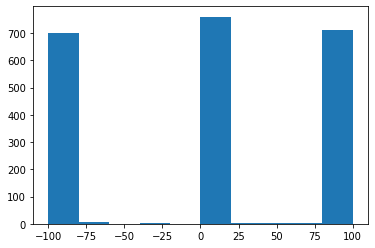

In [49]:
account_values.account_value.describe()

count    2.191000e+03
mean     9.937937e+05
std      1.520213e+05
min      3.836463e+05
25%      9.971941e+05
50%      1.029343e+06
75%      1.050376e+06
max      1.194711e+06
Name: account_value, dtype: float64

<AxesSubplot:>

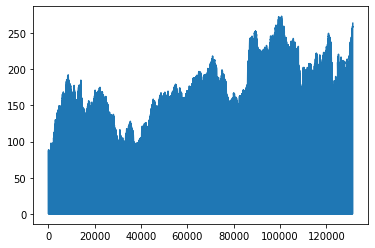

In [44]:
gs.close.plot()

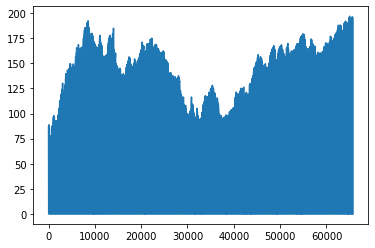

In [45]:
plt.plot(train.close)